# Preprocessing Pipeline

In [1]:
# necessary imports
import pandas as pd
import os
import seaborn as sns

## Data Extraction

In [31]:
# Methods and  lists for data  extraction

def df_to_timeseries(df, timestamp_col="timestamp"):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit="ms") # convert timestamp to datetime
    df.set_index(timestamp_col,inplace=True) # set it as index for TimeSeries purposes
    df = df.tz_localize("UTC") # need to localize a timezone
    df = df.tz_convert("Asia/Seoul") # convert it to Korean timezone
    return df

column_names = ["app_name", "app_category", "ambietal_brightness", "uv_intensity", "longitude", "latitude","altitude"]
entertainment_categories = ['SOCIAL','SHOPPING','BOOKS_AND_REFERENCE',
                            'COMICS','MUSIC_AND_AUDIO', 'GAME','ENTERTAINMENT','VIDEO_PLAYERS', 
                            'SPORTS', 'LIBRARIES_AND_DEMO','NEWS_AND_MAGAZINES']#'COMMUNICATION'?

In [41]:
data_dir = os.path.join(os.getcwd() , "data")
data_files = [f"{name}.csv" for name in ["AppUsageEvent", "Location", "AmbientLight", "UltraViolet"]]
P = {} # Dictionary that'll contain all participant data

for p_code in os.listdir(data_dir):
    if p_code.startswith("P"): # Only get Participant Directories
        pn = int(p_code[1:])
        
        # get tables (and columns) of interest
        app_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "AppUsageEvent.csv")))[["name","category"]]
        app_df = app_df[app_df["category"].isin(entertainment_categories)] # filter for entertainment related apps only
        amb_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "AmbientLight.csv")))
        uv_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "UltraViolet.csv")))[["intensity"]]
        loc_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "Location.csv")))
        loc_df = loc_df[loc_df["accuracy"] < 20][["longitude","latitude","altitude"]].round(4) # remove innacurate readings and reduce precision to 11m
        # merge using merge_asof (we match on nearest timestamp rather than equal timestamps)
        joined_df = pd.merge_asof(app_df, amb_df, left_index=True,right_index=True)
        joined_df = pd.merge_asof(joined_df, uv_df, left_index=True,right_index=True)
        joined_df = pd.merge_asof(joined_df, loc_df, left_index=True,right_index=True)
        joined_df.columns = column_names
        
        # remove duplicates and nan values
        df = joined_df.drop_duplicates().dropna()
        
        P[pn] = joined_df

In [42]:
# Example of a table
P[7].sample(10)

,app_name,app_category,ambietal_brightness,uv_intensity,longitude,latitude,altitude
timestamp,,,,,,,
2019-05-14 02:09:36.165000+09:00,트위터,SOCIAL,18.0,NONE,34.3178,36.3738,95.5000
2019-05-11 17:03:37.837000+09:00,트위터,SOCIAL,16.0,NONE,33.9301,35.9564,60.5000
2019-05-09 19:11:37.273000+09:00,트위터,SOCIAL,3.0,NONE,34.3178,36.3738,91.5000
2019-05-11 17:33:55.113000+09:00,트위터,SOCIAL,16.0,NONE,33.9301,35.9564,60.5000
2019-05-08 13:48:08.387000+09:00,트위터,SOCIAL,414.0,NONE,34.3178,36.3738,91.6000
2019-05-11 20:52:13.814000+09:00,트위터,SOCIAL,15.0,NONE,33.9301,35.9564,60.5000
2019-05-14 13:31:34.279000+09:00,트위터,SOCIAL,18.0,NONE,34.3160,36.3635,74.2000
2019-05-11 12:55:54.096000+09:00,트위터,SOCIAL,11.0,NONE,33.9302,35.9567,34.3658
2019-05-12 12:01:56.259000+09:00,트위터,SOCIAL,0.0,NONE,33.9301,35.9564,60.5000


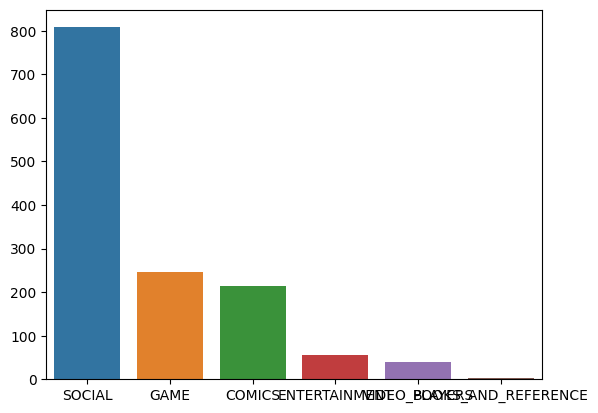

In [38]:
category_counts = P[10]['app_category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values);

In [40]:
P[1].columns

Index(['app_name', 'app_category', 'ambietal_brightness', 'uv_intensity',
       'longitude', 'latitude', 'altitude'],
      dtype='object')